훈련을 위한 데이터셋을 준비합니다. 

여기에서는 VOC데이터셋을 훈련할 것입니다.

VOC데이터셋을 다운로드 받습니다.

In [ ]:
!wget http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar
!rm VOCtrainval_11-May-2012.tar

다운받은 VOC 데이터셋은 이미지에 대한 Annotation이 XML파일로 되어있습니다. 

이를 Darknet에서 훈련할 수 있도록 txt파일로 바꿔주겠습니다.

이 때, 클래스 이름을 정의한 txt파일을 생성합니다. 파일 구조는 아래와 같습니다.



```
aeroplane
bicycle
bird
boat
bottle
bus
car
cat
chair
cow
diningtable
dog
horse
motorbike
person
pottedplant
sheep
sofa
train
tvmonitor
```



In [ ]:
classes = ["aeroplane\n", "bicycle\n", "bird\n", "boat\n", "bottle\n", 
           "bus\n", "car\n", "cat\n", "chair\n", "cow\n", "diningtable\n", 
           "dog\n", "horse\n", "motorbike\n", "person\n", "pottedplant\n", 
           "sheep\n", "sofa\n", "train\n", "tvmonitor"]
with open("vocnames.txt", 'w') as f:
    f.writelines(classes)

In [ ]:
!mkdir VOCdevkit/VOC2012/labels/
!git clone https://github.com/ssaru/convert2Yolo.git
!cd convert2Yolo && python3 example.py --datasets VOC \
--img_path ../VOCdevkit/VOC2012/JPEGImages/ \
--label ../VOCdevkit/VOC2012/Annotations/ \
--convert_output_path ../VOCdevkit/VOC2012/labels/ \
--img_type ".jpg" \
--manifest_path ../ \
--cls_list_file ../vocnames.txt

manifest.txt 파일 내에 훈련에 사용할 이미지들의 리스트가 있습니다. 
이를 7:3의 비율로 훈련과 검증을 위해 분배하겠습니다.

In [ ]:
with open("/content/manifest.txt") as f:
    files = f.readlines()
train_list = []
val_list = []
for idx, img_path in enumerate(files):
    if idx % 10 < 3:
        val_list.append(img_path)
    else:
        train_list.append(img_path)
with open("/content/train.txt", 'w') as f:
    f.writelines(train_list)
with open("/content/val.txt", 'w') as f:
    f.writelines(val_list)

훈련 중 변수 저장을 위해 구글 드라이브를 마운트합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

DarkNet 저장소를 복사합니다.

In [ ]:
# clone darknet repo
!git clone https://github.com/jetsonai/darknet.git

darknet 폴더 아래에 Makefie을 수정합니다.
%cd darknet으로 인해 이후의 명령은 darknet 폴더 내에서 실행됩니다.

In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet 
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

빌드를 수행합니다.

In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make -j$nproc

빌드가 정상적으로 수행되었는지 확인하기 위한 테스트를 수행합니다.

아래 셀을 실행했을 때 bycycle, dog, truck, car에 대한 객체 인식 결과를 확인할 수 있다면 DarkNet 빌드가 정상적으로 수행 된 것입니다.

아래와 유사하게 출력됩니다.

----

data/dog.jpg: Predicted in 5.928000 milli-seconds.

bicycle: 60%

dog: 84%

truck: 79%

car: 46%

----


In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
!./darknet detect cfg/yolov4-tiny.cfg yolov4-tiny.weights data/dog.jpg

Google drive에 Yolov4-tiny 훈련을 위해 전이학습할 가중치를 받아온 후 VOC 데이터셋을 학습할 수 있도록 수정한 yolov4-tiny_voc.cfg 파일을 준비합니다.

아래는 yolov4-tiny_voc.cfg 파일에 대한 설명입니다.

----

해당 파일 내 있는 두 개의 yolo 레이어에서 클래스 수를 20으로 수정합니다.

이후 yolo레이어 바로 위의 convolutional 레이어에서 filters 수를 75로 수정합니다.

75는 ( 5 + 클래스 수 ) * 3을 통해 계산되었습니다.

221번줄의 filters를 75로 변경합니다.

229번줄의 classes를 20으로 변경합니다.

274번줄의 filters를 75로 변경합니다.

280번줄의 classes를 20으로 변경합니다.

```
[convolutional]
...
filters=255  => 75
activation=linear

[yolo]
...
classes=80 => 20
```



----

In [ ]:
!mkdir /content/gdrive/MyDrive/darknet_backup && cd /content/gdrive/MyDrive/darknet_backup && wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29

In [ ]:
!cp cfg/yolov4-tiny.cfg ./yolov4-tiny_voc.cfg
!sed -i "221s/.*/filters=75/g" yolov4-tiny_voc.cfg
!sed -i "229s/.*/classes=20/g" yolov4-tiny_voc.cfg
!sed -i "274s/.*/filters=75/g" yolov4-tiny_voc.cfg
!sed -i "280s/.*/classes=20/g" yolov4-tiny_voc.cfg

훈련을 위한 vocdata_colab.txt 파일을 준비합니다.

훈련할 클래스의 수, 훈련할 데이터셋의 리스트가 적힌 파일의 경로, 클래스의 이름, 훈련 중 가중치가 저장될 폴더의 경로가 아래와 같이 적혀있습니다.

---

classes = 20

train = /content/train.txt

valid = /content/val.txt

names = /content/vocnames.txt

backup = /content/gdrive/MyDrive/darknet_backup

---

In [ ]:
vocdata = ["classes = 20\n", 
           "train = /content/train.txt\n", 
           "valid = /content/val.txt\n"
           "names = /content/vocnames.txt\n",
           "backup = /content/gdrive/MyDrive/darknet_backup"]
with open("vocdata_colab.txt", 'w') as f:
    f.writelines(vocdata)

훈련을 수행합니다.

훈련 중 weights는 실시간으로 구글 드라이브에 저장됩니다.

훈련을 수행하면서 출력되는 로그는 train_log.txt로 저장됩니다.

In [ ]:
!./darknet detector train vocdata_colab.txt yolov4-tiny_voc.cfg /content/gdrive/MyDrive/darknet_backup/yolov4-tiny.conv.29 -dont_show  2&> train_log.txt

**TIP:** 

cfg파일에서 21번 줄의 max_batches 설정에 훈련 시간이 매우 길어길 수 있습니다. 

Colab은 30분 이상 사용자 입력이 없으면 작동이 중지될 수 있습니다.

이를 피하기 위한 팁이 있습니다.

(CTRL + SHIFT + i)을 동시에 누르면 브라우저의 뷰 설정이 열릴 것입니다.

아래의 코드를 console 윈도우에 입력 후 **엔터**를 입력하시면 됩니다.
```
function ClickConnect(){
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect,60000)
```
아래 이미지와 같습니다. 10분마다 윈도우에 클릭 이벤트가 있었다고 자동으로 신호가 갑니다.

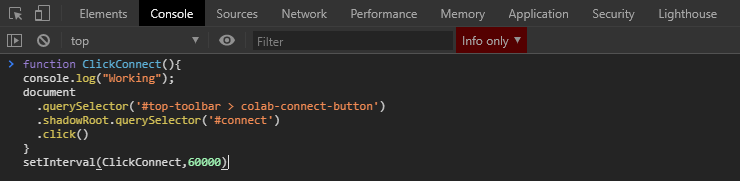

훈련이 어느정도 수행되면 훈련을 중지하셔도 됩니다.

직접 추론하기 위해서 필요한 파일은 아래의 네 가지 파일입니다.

----

vocdata.txt

vocnames.txt

yolov4-tiny_voc.cfg

/content/gdrive/MyDrive/darknet_backup/yolov4-tiny_voc_last.weights

----

만약 추가적으로 학습을 하고자 하는 경우, 아래의 셀을 실행하면 됩니다.

In [ ]:
!./darknet detector train vocdata_colab.txt yolov4-tiny_voc.cfg /content/gdrive/MyDrive/darknet_backup/yolov4-tiny_voc_last.weights -dont_show  2&> train_log.txt